# 1. 폴더 정리

* 제공해드린 animals10.zip의 압축을 풀어 그 내용을 살펴보시고, 폴더 구조를 학습에 알맞도록 재구성해주세요
* 특히 각 클래스마다 약 30% 정도의 이미지를 test 폴더에 할당해주세요
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요 (ex. flat_test[:5]로 앞의 다섯값 확인)
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

In [1]:
# colab 사용할 경우
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Guideline for convenience ###
# 압축 풀기
!unzip -qq "./drive/MyDrive/Colab Notebooks/DSL/animals10.zip"

In [3]:
# import libraries
import glob, os, random, shutil, tqdm
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
# install libraries
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# 각 클래스별 파일 개수 확인 -> 변수로 해당 개수 저장
# Tip) 클래스가 10개이므로 각 클래스마다 똑같은 내용의 코드를 계속 써야할까요? 클래스 이름을 리스트로 저장해 for문을 돌리면서 코드를 재사용하는건 어떨까요?
classes = ('butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel')
animal_counts = []
animal_lists = []

for animal in classes:
  animal_list = sorted(glob.glob(f'./Animals-10/{animal}/*.*'))
  animal_lists.append(animal_list)
  animal_counts.append(len(animal_list))

# check data
for idx, animal in enumerate(classes):
  print(f'Animal: {animal}, len: {animal_counts[idx]}')

Animal: butterfly, len: 2112
Animal: cat, len: 1668
Animal: chicken, len: 3098
Animal: cow, len: 1866
Animal: dog, len: 4863
Animal: elephant, len: 1446
Animal: horse, len: 2623
Animal: sheep, len: 1820
Animal: spider, len: 4821
Animal: squirrel, len: 1862


In [6]:
# test에 넣을 이미지 개수 계산
animal_test_counts = []

for idx, animal in enumerate(classes):
  test_count = round(animal_counts[idx] * 0.3)
  animal_test_counts.append(test_count)
  
# check data
for idx, animal in enumerate(classes):
  print(f'Animal: {animal}, len: {animal_test_counts[idx]}')

Animal: butterfly, len: 634
Animal: cat, len: 500
Animal: chicken, len: 929
Animal: cow, len: 560
Animal: dog, len: 1459
Animal: elephant, len: 434
Animal: horse, len: 787
Animal: sheep, len: 546
Animal: spider, len: 1446
Animal: squirrel, len: 559


In [7]:
# train, test 폴더 경로 선언 & 만들기
animal_train_paths = []
animal_test_paths = []

for idx, animal in enumerate(classes):
  train_path = f'./train/{animal}'
  test_path = f'./test/{animal}'
  animal_train_paths.append(train_path)
  animal_test_paths.append(test_path)
  os.makedirs(train_path, exist_ok=True)
  os.makedirs(test_path, exist_ok=True)

In [8]:
# split 함수 선언
def split(img_list, test_count, train_path, test_path):
  # img_list : 이미지 경로 리스트
  # test_count : test에 할당할 이미지 개수
  # train_path : train 데이터 넣을 경로
  # test_path : test 데이터 넣을 경로
  
  # 랜덤으로 test_count만큼 이미지 img_list에서 고르기
  # test 담을 이미지 리스트 저장
  test_files=[]
  for i in random.sample(img_list, test_count):
    test_files.append(i)

  # 위에서 고르지 않은 이미지들을 train 담을 이미지 리스트로 저장
  train_files = [x for x in img_list if x not in test_files]

  # 고른 이미지를 train_path, test_path폴더에 폭사
  for k in train_files:
    shutil.copy(k, train_path)
  
  for c in test_files:
    shutil.copy(c, test_path)

  print('train 폴더 이미지 개수 : {}\ntest 폴더 이미지 개수 : {}'.format(len(glob.glob(train_path+'/*')),len(glob.glob(test_path+'/*'))))

In [9]:
# train, test 폴더로 이미지 split해서 알맞게 집어넣기
for idx, animal in enumerate(classes):
  split(animal_lists[idx], animal_test_counts[idx], animal_train_paths[idx], animal_test_paths[idx])

train 폴더 이미지 개수 : 1478
test 폴더 이미지 개수 : 634
train 폴더 이미지 개수 : 1168
test 폴더 이미지 개수 : 500
train 폴더 이미지 개수 : 2169
test 폴더 이미지 개수 : 929
train 폴더 이미지 개수 : 1306
test 폴더 이미지 개수 : 560
train 폴더 이미지 개수 : 3404
test 폴더 이미지 개수 : 1459
train 폴더 이미지 개수 : 1012
test 폴더 이미지 개수 : 434
train 폴더 이미지 개수 : 1836
test 폴더 이미지 개수 : 787
train 폴더 이미지 개수 : 1274
test 폴더 이미지 개수 : 546
train 폴더 이미지 개수 : 3375
test 폴더 이미지 개수 : 1446
train 폴더 이미지 개수 : 1303
test 폴더 이미지 개수 : 559


# 2. CNN 모델
수업 코드에 '모델 성능에 대한 고민!!' 부분을 참고해서 **test 이미지 기준 최소 80% 이상**의 모델이 나올 수 있도록 학습을 진행해주세요.
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요
* 90% 이상의 모델이 이상적이긴 합니다
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

전반적으로 수업 코드와 비슷하게 짜면 되는데, 생각해봐야 할 것은
* 모든 이미지를 내가 정의하는 하나의 모델에 넣어야함
* 그말은 input 데이터의 차원이 항상 동일해야 된다는 말
* 그런데 과연 내가 가지고 있는 이미지들의 사이즈가 모두 같을까? - 대략 얼마정도 사이즈 가지고 있는지 코드로 확인해보면 더 좋음 (shape 확인)
* 이미지 사이즈를 통일시키기 위해서는 어떻게 해야할까? - transforms의 Resize, RandomCrop 써볼까?
* 동물 이미지에 적합한 Augmentation은 무엇이 있을까?

In [11]:
# train, test 이미지를 위한 transforms function 정의
# 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!
transform_train = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [12]:
# ImageFolder와 앞서 정의한 transforms function을 활용해 Dataset 객체 (train, test에 대해) 선언
train_data = torchvision.datasets.ImageFolder(
    root = './train', # 바로 train 폴더 지정
    transform = transform_train # transform은 그냥 편의상 cifar에서 썼던거 그대로
)
test_data = torchvision.datasets.ImageFolder(
    root = './test',
    transform = transform_test
)

In [13]:
# train, test에 대해 DataLoader 정의
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 32,      # 일반적으로 batch size = 16, 32
    shuffle=True,         # train dataloader는 epoch마다 데이터 다시 섞어서 batch 만들고 학습! - 학습 효율 up
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = 32,      # 일반적으로 batch size = 16, 32
    shuffle=False,         # train dataloader는 epoch마다 데이터 다시 섞어서 batch 만들고 학습! - 학습 효율 up
    num_workers=2
)

In [14]:
# ### Model 클래스 정의 - 차원에 유의하자!
# # 10개의 클래스를 분류해야 하는 꽤나 복잡한 task - 모델 구조를 어느 정도로 복잡하게 짜볼까?
# # 가장 마지막 Linear의 out_features는 얼마로 해야할까?
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [15]:
# Device 선언 (GPU 권장)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
# torchsummary로 모델 차원 어떻게 나오는지 돌려보기
from torchsummary import summary
test_model = ResNet18().to(device)
summary(test_model, (3,32,32), batch_size=32) # Recall) Tensor는 C, H, W 순서로 이미지 가짐

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
            Conv2d-3           [32, 64, 32, 32]          36,864
       BatchNorm2d-4           [32, 64, 32, 32]             128
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
        BasicBlock-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
           Conv2d-10           [32, 64, 32, 32]          36,864
      BatchNorm2d-11           [32, 64, 32, 32]             128
       BasicBlock-12           [32, 64, 32, 32]               0
           Conv2d-13          [32, 128, 16, 16]          73,728
      BatchNorm2d-14          [32, 128,

In [17]:
# 모델 객체 선언
mymodel = ResNet18().to(device)
mymodel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [18]:
# loss func, optimizer 정의
criterion = nn.CrossEntropyLoss().to(device) # criterion (loss func)도 device 위에서
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.001, weight_decay=0.0001) # 보통 Adam의 learning rate로 0.001 사용
                                                                                  # weight_decay = L2 Regularization의 lambda값 (가중치 제한 정도)

In [19]:
# 추후 시각화를 위해 매 epoch마다 loss, accuracy 값을 저장할 리스트
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [20]:
# train 함수 정의
def train(epoch):
    print(f'\n[ Train epoch: {epoch+1} ]')

    mymodel.train() # train은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하고 진행하기 위함

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어줘야됨
        
        # DL 학습 기본 코드
        optimizer.zero_grad() # gradient 초기화
        outputs = mymodel(inputs) # 현재 batch의 inputs을 모델에 넣어 outputs 추출 (확률값)
        loss = criterion(outputs, targets) # 추출한 outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        optimizer.step() # weight parameter update

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 250 == 249:
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 250 batches: {running_loss / 250}') # 이렇게 출력하는 것이 꼭 필요한 것은 아니지만, 중간중간 확인을 위해 매우 권장
            running_loss = 0.0

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [21]:
# test 함수 정의
def test(epoch):
    print(f'\n[ Test epoch: {epoch+1} ]')

    mymodel.eval() # eval은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하지 않기 위함!
                   # ex. evaluation 할때는 Dropout 없이 지금까지 학습한 모든 node를 활용해서 진행해야됨

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = mymodel(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [22]:
# set epoch
num_epoch = 50

In [23]:
# training
for epoch in range(0, num_epoch):
    train(epoch)
    test(epoch)

# model 저장! - parameter값 저장
torch.save(mymodel.state_dict(), './mymodel.pt')
print('Model Saved!')


[ Train epoch: 1 ]

Current batch: 250
Average train loss of recent 250 batches: 2.2250342030525205

Current batch: 500
Average train loss of recent 250 batches: 2.07961462020874

Total train accuarcy: 23.80900409276944
Total train loss: 2.1336531395687484

[ Test epoch: 1 ]

Test accuarcy: 28.826075884899414
Test average loss: 2.035852831311342

[ Train epoch: 2 ]

Current batch: 250
Average train loss of recent 250 batches: 1.9494063749313355

Current batch: 500
Average train loss of recent 250 batches: 1.8545124211311341

Total train accuarcy: 34.330150068212824
Total train loss: 1.8887941637588421

[ Test epoch: 2 ]

Test accuarcy: 40.01782531194296
Test average loss: 1.7320547964030164

[ Train epoch: 3 ]

Current batch: 250
Average train loss of recent 250 batches: 1.7458093328475952

Current batch: 500
Average train loss of recent 250 batches: 1.6985704803466797

Total train accuarcy: 40.87858117326057
Total train loss: 1.7114142789058453

[ Test epoch: 3 ]

Test accuarcy: 44.0

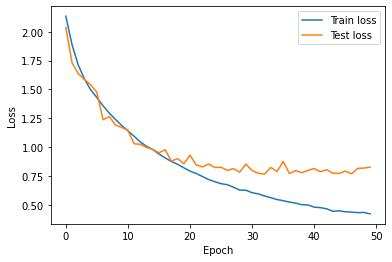

In [24]:
# loss, accuracy 추이 확인 with plt.plot
plt.plot(range(num_epoch), seq_train_loss, label="Train loss")
plt.plot(range(num_epoch), seq_test_loss, label="Test loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

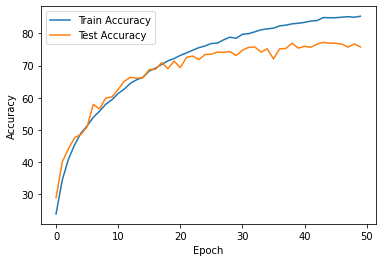

In [25]:
plt.plot(range(num_epoch), seq_train_acc, label="Train Accuracy")
plt.plot(range(num_epoch), seq_test_acc, label="Test Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()